In [7]:
import cv2

In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, classification_report, precision_score, recall_score, f1_score, accuracy_score
import cv2

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ----------------------------
# Transforms (same as feature extraction)
# ----------------------------
normalize = transforms.Normalize((0.5,), (0.5,))

base_transform = transforms.Compose([
    transforms.Resize((28, 28)),
    transforms.ToTensor()
])

normalized_transform = transforms.Compose([
    transforms.Resize((28, 28)),
    transforms.ToTensor(),
    normalize
])

augment_transform = transforms.Compose([
    transforms.Resize((28, 28)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomResizedCrop(28, scale=(0.8, 1.0)),
    transforms.ColorJitter(brightness=0.2),
    transforms.ToTensor(),
    normalize
])

transform_variants = {
    "Base": base_transform,
    "Normalized": normalized_transform,
    "Augmented": augment_transform,
    # "Regularized" uses same augment pipeline but turns on dropout + weight_decay
    "Regularized": augment_transform
}



In [9]:
# ----------------------------
# Simple CNN class with configurable dropout (dropout only used in classifier)
# ----------------------------
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=10, dropout_prob=0.0):
        super(SimpleCNN, self).__init__()
        # conv blocks
        self.conv1 = nn.Conv2d(1, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        # adaptive pool to avoid hardcoding spatial dims
        self.adaptive_pool = nn.AdaptiveAvgPool2d((7, 7))
        # classifier with configurable dropout
        self.dropout_prob = dropout_prob
        self.dropout = nn.Dropout(dropout_prob) if dropout_prob > 0 else nn.Identity()
        self.fc1 = nn.Linear(128 * 7 * 7, 256)
        self.fc2 = nn.Linear(256, num_classes)

    def forward(self, x):
        x = F.relu(self.conv1(x))                  # -> 32 x H x W
        x = self.pool(F.relu(self.conv2(x)))       # -> 64 x H/2 x W/2
        x = self.pool(F.relu(self.conv3(x)))       # -> 128 x H/4 x W/4
        x = self.adaptive_pool(x)                  # -> 128 x 7 x 7
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)                        # dropout only active if dropout_prob>0
        x = self.fc2(x)
        return x



In [10]:
# ----------------------------
# Training & evaluation helpers
# ----------------------------
def train_epoch(model, loader, criterion, optimizer):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        preds = outputs.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
    avg_loss = running_loss / len(loader)
    acc = 100.0 * correct / total
    return avg_loss, acc

def evaluate(model, loader, criterion=None):
    model.eval()
    preds_all, labels_all = [], []
    total_loss = 0.0
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            preds = outputs.argmax(dim=1)
            preds_all.extend(preds.cpu().numpy())
            labels_all.extend(labels.cpu().numpy())
            if criterion is not None:
                total_loss += criterion(outputs, labels).item()
    loss = (total_loss / len(loader)) if (criterion is not None) else None
    acc = 100.0 * (np.array(preds_all) == np.array(labels_all)).mean()
    return acc, loss, np.array(preds_all), np.array(labels_all)



In [11]:
# ----------------------------
# Grad-CAM (uses last conv layer conv3)
# ----------------------------
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None
        self._register_hooks()

    def _register_hooks(self):
        def forward_hook(module, input, output):
            self.activations = output.detach()
        def backward_hook(module, grad_input, grad_output):
            self.gradients = grad_output[0].detach()
        self.target_layer.register_forward_hook(forward_hook)
        self.target_layer.register_backward_hook(backward_hook)

    def generate(self, input_tensor, target_class=None):
        self.model.zero_grad()
        out = self.model(input_tensor)
        if target_class is None:
            target_class = out.argmax(dim=1).item()
        one_hot = torch.zeros_like(out)
        one_hot[0, target_class] = 1
        out.backward(gradient=one_hot, retain_graph=True)

        grads = self.gradients        # BxCxhxw
        acts = self.activations      # BxCxhxw
        weights = grads.mean(dim=(2,3), keepdim=True)  # BxCx1x1
        cam = (weights * acts).sum(dim=1)              # Bxhxw
        cam = F.relu(cam)
        cam = cam.squeeze().cpu().numpy()
        cam = (cam - cam.min()) / (cam.max() - cam.min() + 1e-8)
        return cam, target_class




=== Running variant: Base ===
Epoch [1/10] Train Loss: 0.1768 Train Acc: 94.51% | Val Loss: 0.0405 Val Acc: 98.84%
Epoch [2/10] Train Loss: 0.0399 Train Acc: 98.78% | Val Loss: 0.0303 Val Acc: 98.97%
Epoch [3/10] Train Loss: 0.0260 Train Acc: 99.20% | Val Loss: 0.0227 Val Acc: 99.22%
Epoch [4/10] Train Loss: 0.0193 Train Acc: 99.39% | Val Loss: 0.0335 Val Acc: 98.95%
Epoch [5/10] Train Loss: 0.0150 Train Acc: 99.50% | Val Loss: 0.0311 Val Acc: 98.94%
Epoch [6/10] Train Loss: 0.0122 Train Acc: 99.59% | Val Loss: 0.0271 Val Acc: 99.23%
Epoch [7/10] Train Loss: 0.0087 Train Acc: 99.70% | Val Loss: 0.0324 Val Acc: 99.04%
Epoch [8/10] Train Loss: 0.0076 Train Acc: 99.75% | Val Loss: 0.0306 Val Acc: 99.15%
Epoch [9/10] Train Loss: 0.0084 Train Acc: 99.71% | Val Loss: 0.0286 Val Acc: 99.18%
Epoch [10/10] Train Loss: 0.0049 Train Acc: 99.83% | Val Loss: 0.0340 Val Acc: 99.27%
Final Test Acc: 99.27%  Prec: 0.9926 Rec: 0.9926 F1: 0.9926
Classification report:
               precision    recall 

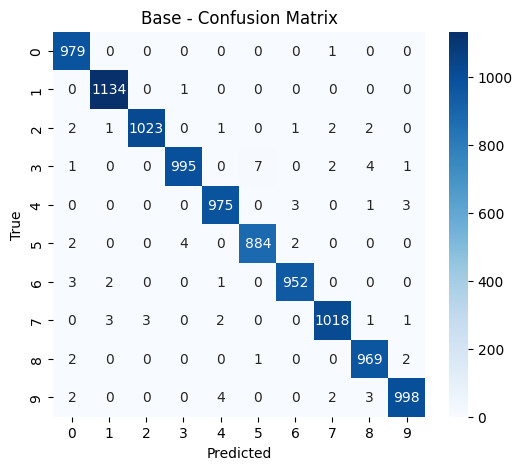

/tmp/ipykernel_2051/1684486728.py:60: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  idx = np.where(np.array(test_ds.targets) == i)[0][0]
/home/bryan_santosa/miniconda3/envs/machinelearning/lib/python3.10/site-packages/torch/nn/modules/module.py:1864: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


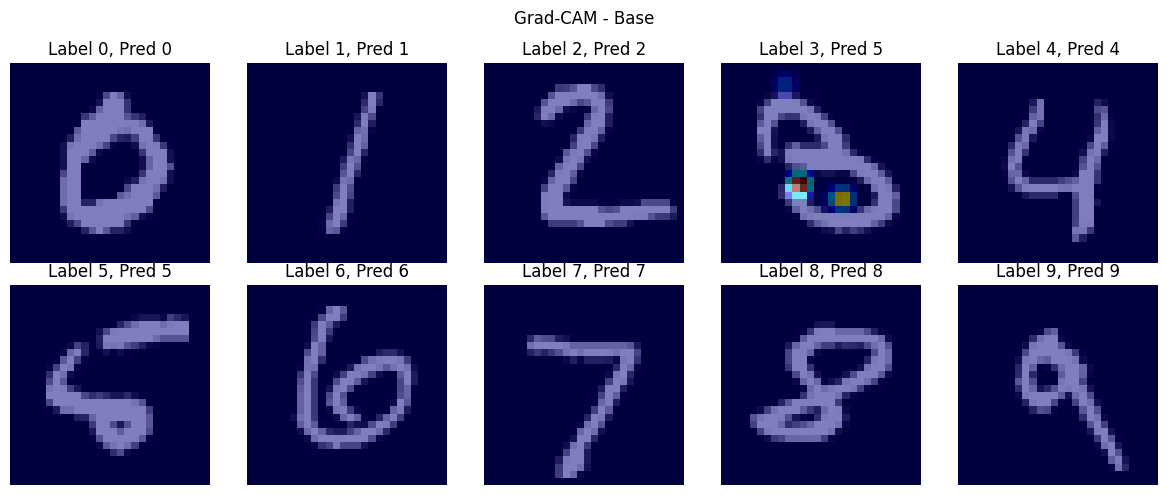


=== Running variant: Normalized ===
Epoch [1/10] Train Loss: 0.1556 Train Acc: 95.30% | Val Loss: 0.0378 Val Acc: 98.78%
Epoch [2/10] Train Loss: 0.0387 Train Acc: 98.83% | Val Loss: 0.0262 Val Acc: 99.09%
Epoch [3/10] Train Loss: 0.0240 Train Acc: 99.23% | Val Loss: 0.0256 Val Acc: 99.19%
Epoch [4/10] Train Loss: 0.0169 Train Acc: 99.48% | Val Loss: 0.0251 Val Acc: 99.29%
Epoch [5/10] Train Loss: 0.0126 Train Acc: 99.58% | Val Loss: 0.0348 Val Acc: 98.91%
Epoch [6/10] Train Loss: 0.0108 Train Acc: 99.65% | Val Loss: 0.0313 Val Acc: 99.06%
Epoch [7/10] Train Loss: 0.0097 Train Acc: 99.66% | Val Loss: 0.0271 Val Acc: 99.27%
Epoch [8/10] Train Loss: 0.0061 Train Acc: 99.79% | Val Loss: 0.0276 Val Acc: 99.26%
Epoch [9/10] Train Loss: 0.0073 Train Acc: 99.77% | Val Loss: 0.0377 Val Acc: 99.03%
Epoch [10/10] Train Loss: 0.0078 Train Acc: 99.72% | Val Loss: 0.0297 Val Acc: 99.25%
Final Test Acc: 99.25%  Prec: 0.9925 Rec: 0.9924 F1: 0.9925
Classification report:
               precision    r

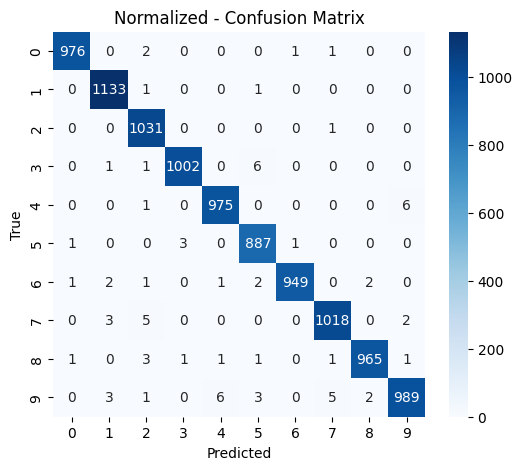

/tmp/ipykernel_2051/1684486728.py:60: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  idx = np.where(np.array(test_ds.targets) == i)[0][0]
/home/bryan_santosa/miniconda3/envs/machinelearning/lib/python3.10/site-packages/torch/nn/modules/module.py:1864: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


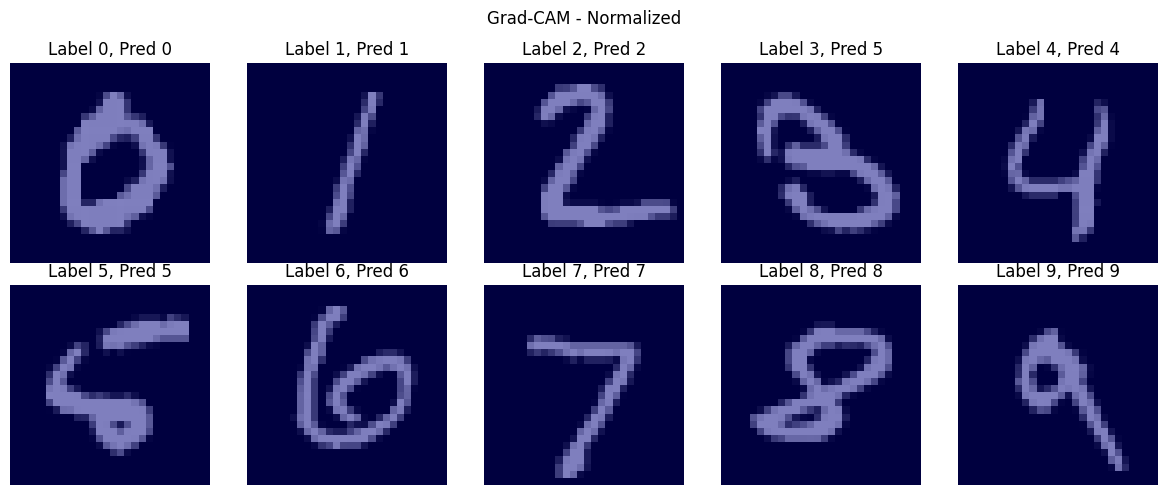


=== Running variant: Augmented ===
Epoch [1/10] Train Loss: 0.3349 Train Acc: 89.15% | Val Loss: 0.1169 Val Acc: 96.18%
Epoch [2/10] Train Loss: 0.1002 Train Acc: 96.81% | Val Loss: 0.0813 Val Acc: 97.35%
Epoch [3/10] Train Loss: 0.0746 Train Acc: 97.65% | Val Loss: 0.0592 Val Acc: 98.20%
Epoch [4/10] Train Loss: 0.0629 Train Acc: 98.07% | Val Loss: 0.0507 Val Acc: 98.26%
Epoch [5/10] Train Loss: 0.0537 Train Acc: 98.31% | Val Loss: 0.0533 Val Acc: 98.15%
Epoch [6/10] Train Loss: 0.0494 Train Acc: 98.47% | Val Loss: 0.0535 Val Acc: 98.33%
Epoch [7/10] Train Loss: 0.0472 Train Acc: 98.54% | Val Loss: 0.0473 Val Acc: 98.42%
Epoch [8/10] Train Loss: 0.0416 Train Acc: 98.70% | Val Loss: 0.0512 Val Acc: 98.30%
Epoch [9/10] Train Loss: 0.0389 Train Acc: 98.76% | Val Loss: 0.0451 Val Acc: 98.53%
Epoch [10/10] Train Loss: 0.0355 Train Acc: 98.89% | Val Loss: 0.0450 Val Acc: 98.49%
Final Test Acc: 98.45%  Prec: 0.9841 Rec: 0.9844 F1: 0.9842
Classification report:
               precision    re

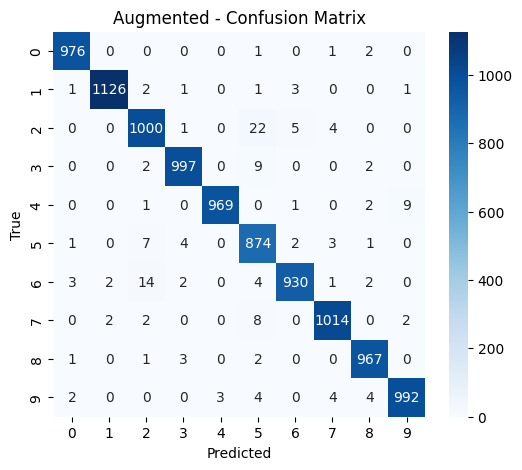

/tmp/ipykernel_2051/1684486728.py:60: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  idx = np.where(np.array(test_ds.targets) == i)[0][0]
/home/bryan_santosa/miniconda3/envs/machinelearning/lib/python3.10/site-packages/torch/nn/modules/module.py:1864: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


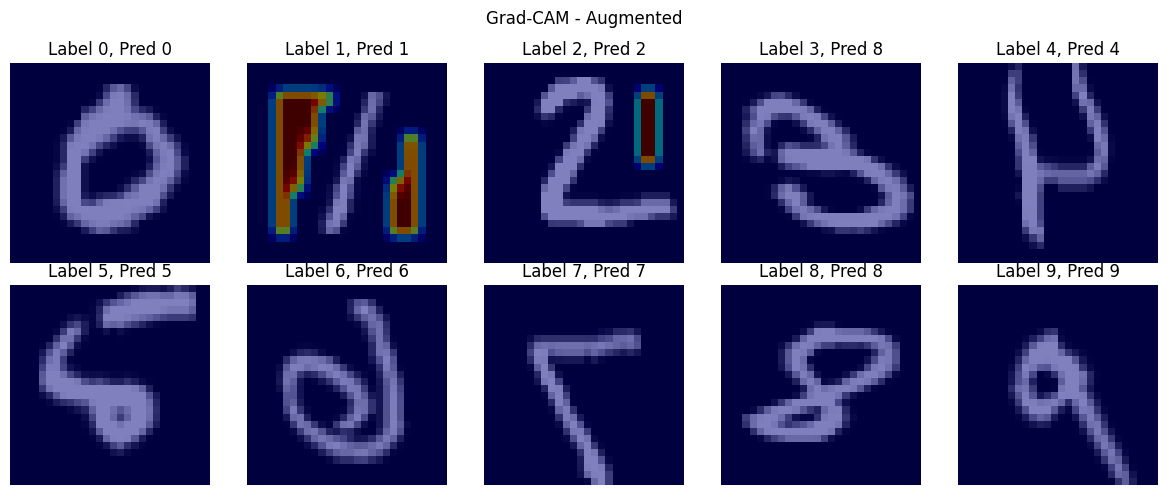


=== Running variant: Regularized ===
Epoch [1/10] Train Loss: 0.4122 Train Acc: 86.74% | Val Loss: 0.1015 Val Acc: 96.70%
Epoch [2/10] Train Loss: 0.1488 Train Acc: 95.39% | Val Loss: 0.0812 Val Acc: 97.26%
Epoch [3/10] Train Loss: 0.1166 Train Acc: 96.51% | Val Loss: 0.0614 Val Acc: 98.00%
Epoch [4/10] Train Loss: 0.0983 Train Acc: 97.08% | Val Loss: 0.0526 Val Acc: 98.16%
Epoch [5/10] Train Loss: 0.0906 Train Acc: 97.27% | Val Loss: 0.0496 Val Acc: 98.39%
Epoch [6/10] Train Loss: 0.0801 Train Acc: 97.59% | Val Loss: 0.0473 Val Acc: 98.49%
Epoch [7/10] Train Loss: 0.0768 Train Acc: 97.64% | Val Loss: 0.0451 Val Acc: 98.55%
Epoch [8/10] Train Loss: 0.0715 Train Acc: 97.82% | Val Loss: 0.0473 Val Acc: 98.53%
Epoch [9/10] Train Loss: 0.0687 Train Acc: 97.82% | Val Loss: 0.0430 Val Acc: 98.70%
Epoch [10/10] Train Loss: 0.0694 Train Acc: 97.92% | Val Loss: 0.0419 Val Acc: 98.64%
Final Test Acc: 98.53%  Prec: 0.9851 Rec: 0.9851 F1: 0.9851
Classification report:
               precision    

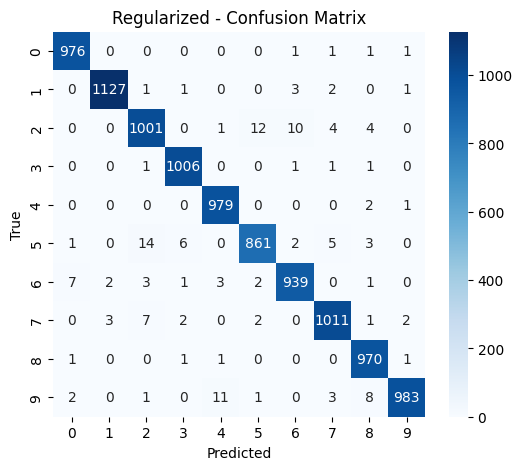

/tmp/ipykernel_2051/1684486728.py:60: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  idx = np.where(np.array(test_ds.targets) == i)[0][0]
/home/bryan_santosa/miniconda3/envs/machinelearning/lib/python3.10/site-packages/torch/nn/modules/module.py:1864: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


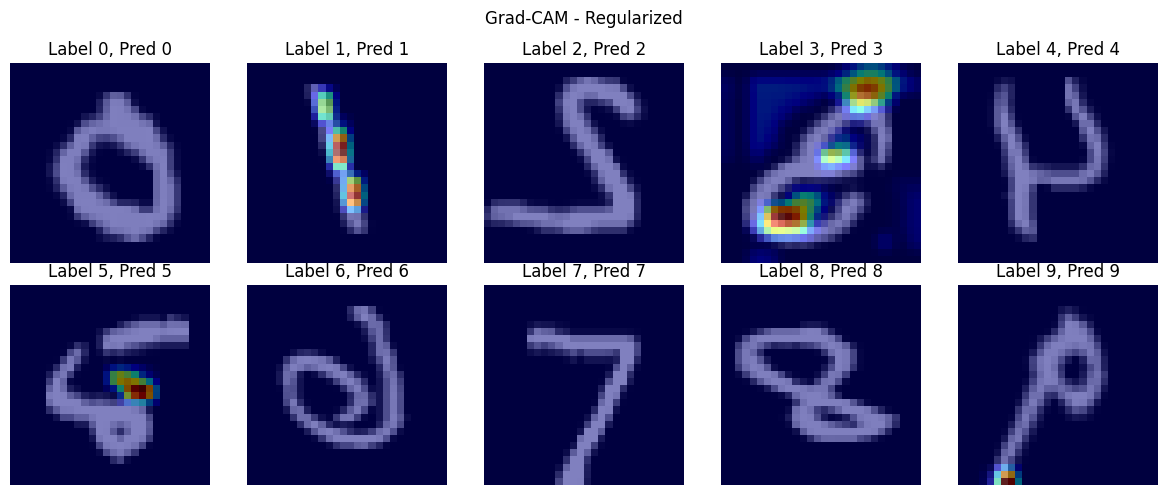

In [12]:
# ----------------------------
# Main loop: training all variations properly (dropout + weight_decay only for Regularized)
# ----------------------------
results = {}
num_epochs = 10
batch_size = 128
criterion = nn.CrossEntropyLoss()

for name, transform in transform_variants.items():
    print(f"\n=== Running variant: {name} ===")
    train_ds = datasets.MNIST(root="./data", train=True, download=True, transform=transform)
    test_ds  = datasets.MNIST(root="./data", train=False, download=True, transform=transform)
    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
    test_loader  = DataLoader(test_ds,  batch_size=1000, shuffle=False)

    # regularize logic: enable dropout in model and weight decay in optimizer only for 'Regularized'
    is_regularize = (name == "Regularized")
    dropout_prob = 0.5 if is_regularize else 0.0

    model = SimpleCNN(num_classes=10, dropout_prob=dropout_prob).to(device)

    weight_decay = 1e-4 if is_regularize else 0.0
    optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=weight_decay)

    # History containers
    history = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}

    # Train
    for epoch in range(num_epochs):
        train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer)
        val_acc, val_loss, _, _ = evaluate(model, test_loader, criterion)
        history["train_loss"].append(train_loss)
        history["train_acc"].append(train_acc)
        history["val_loss"].append(val_loss)
        history["val_acc"].append(val_acc)
        print(f"Epoch [{epoch+1}/{num_epochs}] Train Loss: {train_loss:.4f} Train Acc: {train_acc:.2f}% | Val Loss: {val_loss:.4f} Val Acc: {val_acc:.2f}%")

    # Final evaluation metrics (detailed)
    test_acc, _, preds, labels = evaluate(model, test_loader)
    prec = precision_score(labels, preds, average='macro')
    rec  = recall_score(labels, preds, average='macro')
    f1   = f1_score(labels, preds, average='macro')
    print(f"Final Test Acc: {test_acc:.2f}%  Prec: {prec:.4f} Rec: {rec:.4f} F1: {f1:.4f}")
    print("Classification report:\n", classification_report(labels, preds, digits=4))

    # Confusion matrix
    cm = confusion_matrix(labels, preds)
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f"{name} - Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

    # Grad-CAM: visualize one example per class (2x5 grid)
    gradcam = GradCAM(model, model.conv3)
    fig, axes = plt.subplots(2, 5, figsize=(12,5))
    axes_flat = axes.flatten()
    for i in range(10):
        idx = np.where(np.array(test_ds.targets) == i)[0][0]
        img, _ = test_ds[idx]
        inp = img.unsqueeze(0).to(device)
        inp.requires_grad_()
        cam, cls = gradcam.generate(inp)
        cam_resized = cv2.resize(cam, (img.shape[2], img.shape[1]))
        ax = axes_flat[i]
        ax.imshow(img.squeeze().cpu().numpy(), cmap='gray')
        ax.imshow(cam_resized, cmap='jet', alpha=0.5)
        ax.set_title(f"Label {i}, Pred {cls}")
        ax.axis("off")
    plt.suptitle(f"Grad-CAM - {name}")
    plt.tight_layout()
    plt.show()

    # store results
    results[name] = {"history": history, "test_acc": test_acc, "prec": prec, "rec": rec, "f1": f1, "cm": cm}



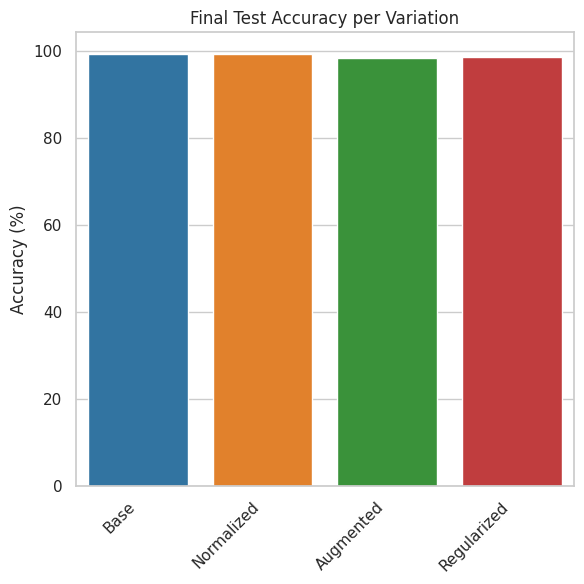

In [23]:
# Summary bar chart (final test accuracy)
import pandas as pd
names = list(results.keys())
accs  = [results[n]["test_acc"] for n in names]
df = pd.DataFrame({
    'Variation': names,
    'Accuracy': accs
})

plt.figure(figsize=(6,6))
sns.set_theme(style="whitegrid")

ax = sns.barplot(
    data=df,
    x='Variation',
    y='Accuracy',
    hue='Variation',
    dodge=False,
    palette='tab10',
    legend=False
)

ax.set_title("Final Test Accuracy per Variation")
ax.set_ylabel("Accuracy (%)")
ax.set_xlabel(None)

plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

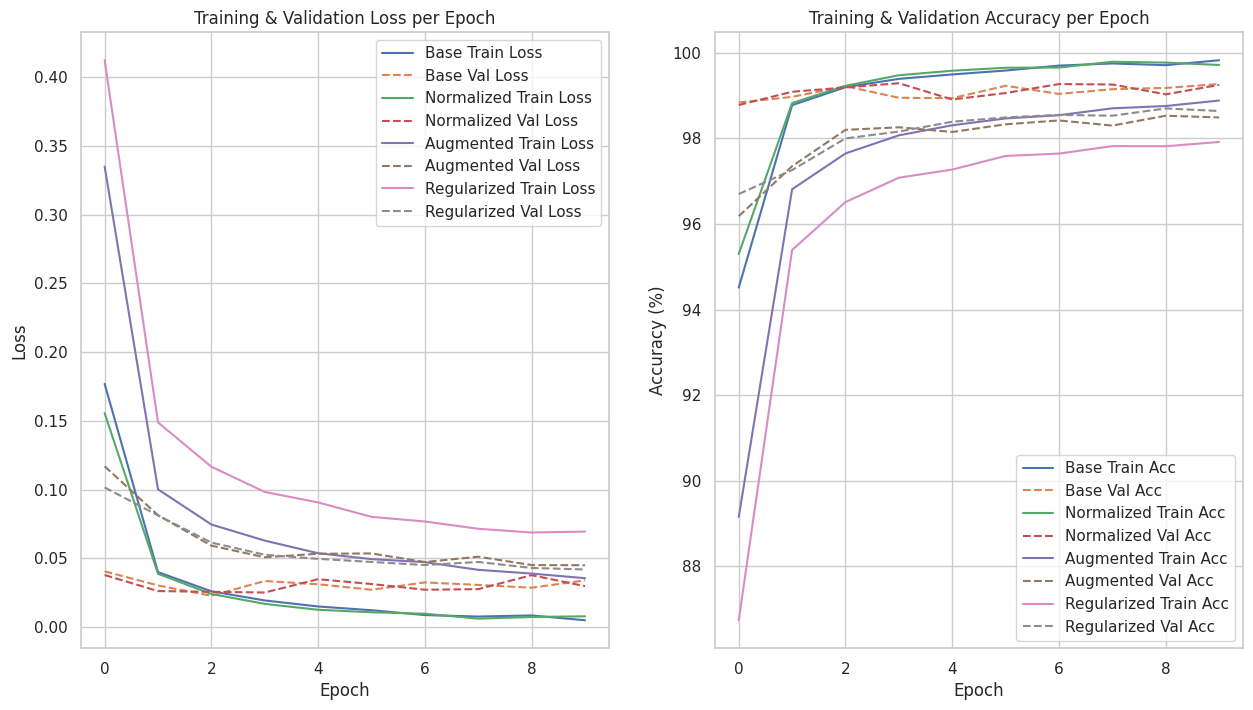

In [27]:
# ----------------------------
# Plot loss & accuracy curves for all variants
# ----------------------------
plt.figure(figsize=(15,8))
plt.subplot(1,2,1)

for name, res in results.items():
    history = res["history"]
    plt.plot(history["train_loss"], label=f"{name} Train Loss")
    plt.plot(history["val_loss"], linestyle="--", label=f"{name} Val Loss")

plt.title("Training & Validation Loss per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
# plt.show()

# Plot accuracy curves
plt.subplot(1,2,2)
for name, res in results.items():
    history = res["history"]
    plt.plot(history["train_acc"], label=f"{name} Train Acc")
    plt.plot(history["val_acc"], linestyle="--", label=f"{name} Val Acc")

plt.title("Training & Validation Accuracy per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.legend()
plt.grid(True)
plt.show()


In [29]:
import pickle

with open("results_cnnbaseline.pkl", "wb") as f:
    pickle.dump(results, f)
